# Informix Common Table Expression Demo

<pre>
A common table expression (CTE) is a named temporary result set that exists within the scope of a single statement and that can be referred to later within that statement, possibly multiple times.
</pre>
### Syntax

<pre>
|--WITH -------------------------------------------------------------------------> (1)

     .-,-----------------------------------------------------------------------+  
     V                                                                         |
(1)----- cte_name ---+---------------------+--AS (Subset of SELECT statement)--+-> (2)    
                      |    .-,--------.    |           
                      |    V          |    |           
                      '-(----column---+--)-'  
                                                                
(2)----- SELECT/UPDATE/INSERT/DELETE statement
</pre>

In [1]:
# create a database
cmd = """
dbaccess - - <<EOT!
drop database if exists cte;
create database cte with log;
EOT!
"""
!{cmd}


Database dropped.


Database created.



Database closed.



In [2]:
import numpy as np
import pandas as pd

In [3]:
from pandas import DataFrame

In [4]:
# https://github.com/OpenInformix/IfxPy
import IfxPy
import IfxPyDbi as dbapi2

In [5]:
constr = "SERVER=xx2;database=cte;HOST=127.0.0.1;SERVICE=19200;UID=informix;PWD=in4mix10"

In [6]:
conn = dbapi2.connect(constr, "", "")

In [7]:
cur = conn.cursor()

In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

## 1 - Simple CTE

In [9]:
# query without from
s = "SELECT 1,2,TODAY"
cur.execute(s)
t = cur.fetchall()

In [10]:
columns = ['expr1', 'expr2', 'expr3']
df = pd.DataFrame(data=t, columns=columns)

In [11]:
df

,expr1,expr2,expr3
0,1,2,2020-06-16


In [12]:
# A simple CTE query with multiple references
s = """
WITH cte(a, b, c) as (SELECT 1,2,3)
SELECT * from cte 
UNION ALL 
SELECT a+3, b+4, c+5 from cte
UNION ALL 
SELECT a+13, b+14, c+15 from cte
"""
cur.execute(s)
t = cur.fetchall()

In [13]:
columns = ['expr1', 'expr2', 'expr3']
df = pd.DataFrame(data=t, columns=columns)

In [14]:
df

,expr1,expr2,expr3
0,1,2,3
1,4,6,8
2,14,16,18


In [15]:
# A simple CTE query with multiple ctes
s = """
WITH cte1 as (SELECT 1,2,3),
     cte2 as (SELECT 4,5,6),
     cte3 as (SELECT 14,15,16)
SELECT * from cte1 
UNION ALL 
SELECT * from cte2
UNION ALL 
SELECT * from cte3
"""
cur.execute(s)
t = cur.fetchall()

In [16]:
columns = ['expr1', 'expr2', 'expr3']
df = pd.DataFrame(data=t, columns=columns)

In [17]:
df

,expr1,expr2,expr3
0,1,2,3
1,4,5,6
2,14,15,16


## 2 - Fibonacci Sequence

In [18]:
s = """
WITH fib(p, n) as
(
    select 0, 1 -- initial values
    UNION ALL
    select n, (p+n)
        from fib -- recursive subquery
        where n < 100
)
select p from fib;
"""
cur.execute(s)
t = cur.fetchall()

In [19]:
columns = ['p']
df = pd.DataFrame(data=t, columns=columns)

In [20]:
df

,p
0,0
1,1
2,1
3,2
4,3
5,5
6,8
7,13
8,21
9,34


## 3 - Recursive CTE Use Case 1: Tree/Hierarchic Dataset 

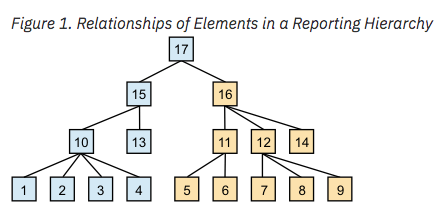

In [21]:
from IPython.display import display, Image
display(Image(filename='employee.png'))

In [22]:
cur.execute("drop table if exists employee;")

cur.execute("""CREATE TABLE employee(
                      empid  INTEGER NOT NULL PRIMARY KEY,
                      name   CHAR(10),
                      mgrid  INTEGER
);""")

cur.execute("INSERT INTO employee VALUES  ( 1, 'Jones',     10);")
cur.execute("INSERT INTO employee VALUES  ( 2, 'Hall',      10);")
cur.execute("INSERT INTO employee VALUES  ( 3, 'Kim',       10);")
cur.execute("INSERT INTO employee VALUES  ( 4, 'Lindsay',   10);")
cur.execute("INSERT INTO employee VALUES  ( 5, 'McKeough',  11);")
cur.execute("INSERT INTO employee VALUES  ( 6, 'Barnes',    11);")
cur.execute("INSERT INTO employee VALUES  ( 7, 'ONeil',     12);")
cur.execute("INSERT INTO employee VALUES  ( 8, 'Smith',     12);")
cur.execute("INSERT INTO employee VALUES  ( 9, 'Shoeman',   12);")
cur.execute("INSERT INTO employee VALUES  (10, 'Monroe',    15);")
cur.execute("INSERT INTO employee VALUES  (11, 'Zander',    16);")
cur.execute("INSERT INTO employee VALUES  (12, 'Henry',     16);")
cur.execute("INSERT INTO employee VALUES  (13, 'Aaron',     15);")
cur.execute("INSERT INTO employee VALUES  (14, 'Scott',     16);")
cur.execute("INSERT INTO employee VALUES  (15, 'Mills',     17);")
cur.execute("INSERT INTO employee VALUES  (16, 'Goyal',     17);")
cur.execute("INSERT INTO employee VALUES  (17, 'Urbassek',  NULL);")


True

In [23]:
# Query employees reporting to Goyal
s = """
WITH cte AS (
  SELECT empid, name, mgrid, 1 AS level
    FROM employee
    WHERE name = 'Mills'
  UNION ALL
  SELECT t.empid, t.name, t.mgrid, (cte.level + 1)
    FROM employee t, cte
  where cte.empid = t.mgrid
  )
SELECT * from cte ;
"""
cur.execute(s)
t = cur.fetchall()

In [24]:
columns = ['empid', 'name', 'mgrid', 'level']
df = pd.DataFrame(data=t, columns=columns)

In [25]:
df

,empid,name,mgrid,level
0,15,Mills,17,1
1,13,Aaron,15,2
2,10,Monroe,15,2
3,4,Lindsay,10,3
4,3,Kim,10,3
5,2,Hall,10,3
6,1,Jones,10,3


## 4 - Recursive CTE Use Case 2: Graph Dataset
<pre>
we have a graph dataset with 6 cities A, B, C, D, E, and F, also we have cost for each road between cities.
</pre>

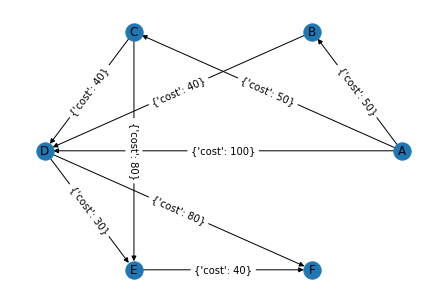

In [26]:
from IPython.display import display, Image
display(Image(filename='location.png'))

In [27]:
cur.execute("drop table if exists loc;")
cur.execute("create table loc (id int, name char(10));")
cur.execute("insert into loc values (1, 'A');")
cur.execute("insert into loc values (2, 'B');")
cur.execute("insert into loc values (3, 'C');")
cur.execute("insert into loc values (4, 'D');")
cur.execute("insert into loc values (5, 'E');")
cur.execute("insert into loc values (6, 'F');")
cur.execute("create index loc_idx1 on loc(id);")
cur.execute("create index loc_idx2 on loc(name);")

cur.execute("drop table if exists road;")
cur.execute("create table road(start int, end int, cost int);")
cur.execute("insert into road values (1, 2, 50);")
cur.execute("insert into road values (1, 3, 50);")
cur.execute("insert into road values (1, 4, 100);")
cur.execute("insert into road values (2, 4, 40);")
cur.execute("insert into road values (3, 4, 40);")
cur.execute("insert into road values (3, 5, 80);")
cur.execute("insert into road values (4, 5, 30);")
cur.execute("insert into road values (4, 6, 80);")
cur.execute("insert into road values (5, 6, 40);")
cur.execute("create index road_idx1 on road(start, end);")

True

In [28]:
# list all path from A to F order by total cost
s = """
with cte(id, path, cost, name, level) as (
    SELECT f.id, (trim(a.name) || " -> " || f.name)::lvarchar, 
        r.cost, f.name, 1
        FROM loc a, road r, loc f
        WHERE a.name = 'A' AND r.start = a.id AND r.end = f.id
    UNION ALL
    SELECT f.id, trim(a.path) || " -> " || trim(f.name), 
        a.cost + r.cost,
        f.name, level + 1
        FROM cte a, road r, loc f
        WHERE r.start = a.id AND r.end = f.id
)
select path, cost, level from cte   
where name = 'F'
order by cost;
"""
cur.execute(s)
t = cur.fetchall()

In [29]:
columns = ['PATH', 'COST', 'connections']
df = pd.DataFrame(data=t, columns=columns)

In [30]:
df

,PATH,COST,connections
0,A -> B -> D -> E -> F,160,4
1,A -> C -> D -> E -> F,160,4
2,A -> D -> E -> F,170,3
3,A -> C -> D -> F,170,3
4,A -> B -> D -> F,170,3
5,A -> C -> E -> F,170,3
6,A -> D -> F,180,2


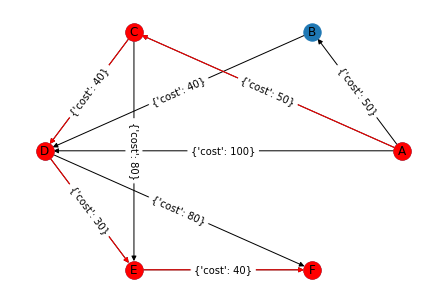

In [31]:
from IPython.display import display, Image
display(Image(filename='location_lowcost.png'))

## 5 - CTE Fun Queries

### 5.0 - Group Aggregation Helper Function

In [32]:
# helper function for group aggregation
cur.execute("drop function if exists plus(lvarchar, lvarchar);")
cur.execute("""
create function plus(s1 lvarchar, s2 lvarchar)
    returning lvarchar;
    return s1 || s2;
end function;
""")

True

### 5.1 - Mandelbrot Set
<pre>
We will draw Mandelbrot in simple Python code, and then do it with SQL query.
</pre>

In [33]:
# Mandelbrot in Python
from PIL import Image, ImageDraw
im = Image.new('RGB', (280, 120), (0, 0, 0))
draw = ImageDraw.Draw(im)

In [34]:
# https://en.wikipedia.org/wiki/Mandelbrot_set
for x in range(-70 * 2, 70 * 2):
    for y in range(-30 * 2, 30 * 2):
        n = 0
        x0 = 0.015 * x
        y0 = 0.02 * y
        rx = 0
        ix = 0
        while rx*rx + ix*ix <= 2 and n < 100:
            tx = rx *rx - ix* ix + x0
            ix = 2 * rx * ix + y0
            rx = tx
            n = n + 1
        color = 255 - int(n * 255 / 99)
        # Plot the point
        draw.point([x + 140, y + 60], (color, color, color))

im.save('mandelbrot.png', 'PNG')

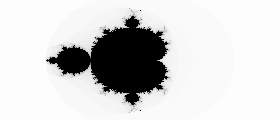

In [35]:
from IPython.display import display, Image
display(Image(filename='mandelbrot.png'))

In [36]:
# Mandelbrot in informix SQL
# port from PostgreSQL https://explainextended.com/2013/12/31/happy-new-year-5/
s = """
WITH    
x(n) AS ( select -70 UNION ALL select n+1 from x where n < 40),
y(j) AS ( select -30 UNION ALL select j+1 from y where j < 30),
q (r, i, rx, ix, g) AS (
    SELECT  n::float * 0.02, j::float * 0.04, 0::float, 0::float, 0
        FROM (select n from x) cross join (select j from y)
    UNION ALL
    SELECT  r, i, 
        CASE WHEN ABS(rx * rx + ix * ix) <= 2 THEN rx * rx - ix * ix END + r, 
        CASE WHEN ABS(rx * rx + ix * ix) <= 2 THEN 2 * rx * ix END + i, 
        g + 1
        FROM q WHERE rx IS NOT NULL AND g < 100),
Zt (i, r, x) AS (
    SELECT i, r, SUBSTR('@@B%8&WM#*oaqwmO0Ucrt/\|()1{}[]?-_+~<>i!l;;:,```.', 
        50 - (MAX(g)/2)::int, 1) as x
        FROM q GROUP BY i, r order by r desc)
SELECT  sum(x::lvarchar) as x from Zt group by i order by i;
"""
cur.execute(s)
t = cur.fetchall()

In [37]:
columns = ['x']
df = pd.DataFrame(data=t, columns=columns)

In [38]:
print(df)

                                                                                                                  x
0   ...............................................................................................................
1   ...............................................................................................................
2   ...............................................................................................................
3   ...............................................................................................................
4   ............................``````````````````````````````````l................................................
5   ....................``````````````````````````````````````````,;,,,`,l@........................................
6   ...................````````````````````````````````````````````,:l;,````````...................................
7   .................``````````````````````````````````````````````:l!:,

### 5.2 - Julia Set

In [39]:
# Query to generate a Julia Set (a beautiful tree like image)
# port from PostgreSQL https://explainextended.com/2013/12/31/happy-new-year-5/
# https://en.wikipedia.org/wiki/Julia_set
s = """
WITH    
x(n) AS (
    select -40
    UNION ALL
    select n+1 from x where n < 40),
q (r, i, rx, ix, g) AS (
    SELECT  x + r::float * step, y + i::float * step,
            x + r::float * step, y + i::float * step,
            0
    FROM    (
        SELECT  0.25 x, -0.55 y, 0.002 step, r, i
            FROM (select n as r from x) 
        cross join 
        (select n as i from x))
        UNION ALL
        SELECT  r, i,
                CASE WHEN (rx * rx + ix * ix) < 1E8 THEN 
                pow((rx * rx + ix * ix), 0.75) * COS(1.5 * ATAN2(ix, rx)) END - 0.2,
                CASE WHEN (rx * rx + ix * ix) < 1E8 THEN 
                pow((rx * rx + ix * ix), 0.75) * SIN(1.5 * ATAN2(ix, rx)) END,
                g + 1
        FROM    q
        WHERE   rx IS NOT NULL
                AND g < 99
        ),
Zt (i, r, x) AS (
    SELECT i, r, SUBSTR(" .:-=+*#%@", (MAX(g) /10 +1)::int, 1) as x
    FROM q
    GROUP BY i, r
    order by r)
SELECT  
    sum(x::lvarchar) as x
    from Zt 
    group by i
    order by i;
"""
cur.execute(s)
t = cur.fetchall()

In [40]:
columns = ['']
df = pd.DataFrame(data=t, columns=columns)

In [41]:
print(df)

                                                                                     
0   :::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
1   :::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
2   :::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
3   :::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
4   :::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
5   :::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
6   ::::::::::::::::::::::::::::::::::------------------------:::::::::::::::::::::::
7   :::::::::::::::::::::::::::-------------------------------------:::::::::::::::::
8   ::::::::::::::::::::::----------------------------------------------:::::::::::::
9   ::::::::::::::::::-----------------------------------------------------::::::::::
10  :::::::::::::::-----------------=======+*@@@@@@@@@

### 5.3 - Thank You

In [42]:
# SQL version banner
s = """
with fonts(c, c1, c2,c3,c4,c5,c6,c7,c8) as (
select * from table(multiset{
ROW(' ' , '0x00' , '0x00' , '0x00' , '0x00' , '0x00' , '0x00' , '0x00' , '0x00') , 
ROW('!' , '0x18' , '0x3C' , '0x3C' , '0x18' , '0x18' , '0x00' , '0x18' , '0x00') , 
ROW('A' , '0x0C' , '0x1E' , '0x33' , '0x33' , '0x3F' , '0x33' , '0x33' , '0x00') , 
ROW('B' , '0x3F' , '0x66' , '0x66' , '0x3E' , '0x66' , '0x66' , '0x3F' , '0x00') , 
ROW('C' , '0x3C' , '0x66' , '0x03' , '0x03' , '0x03' , '0x66' , '0x3C' , '0x00') , 
ROW('D' , '0x1F' , '0x36' , '0x66' , '0x66' , '0x66' , '0x36' , '0x1F' , '0x00') , 
ROW('E' , '0x7F' , '0x46' , '0x16' , '0x1E' , '0x16' , '0x46' , '0x7F' , '0x00') , 
ROW('F' , '0x7F' , '0x46' , '0x16' , '0x1E' , '0x16' , '0x06' , '0x0F' , '0x00') , 
ROW('G' , '0x3C' , '0x66' , '0x03' , '0x03' , '0x73' , '0x66' , '0x7C' , '0x00') , 
ROW('H' , '0x33' , '0x33' , '0x33' , '0x3F' , '0x33' , '0x33' , '0x33' , '0x00') , 
ROW('I' , '0x1E' , '0x0C' , '0x0C' , '0x0C' , '0x0C' , '0x0C' , '0x1E' , '0x00') , 
ROW('J' , '0x78' , '0x30' , '0x30' , '0x30' , '0x33' , '0x33' , '0x1E' , '0x00') , 
ROW('K' , '0x67' , '0x66' , '0x36' , '0x1E' , '0x36' , '0x66' , '0x67' , '0x00') , 
ROW('L' , '0x0F' , '0x06' , '0x06' , '0x06' , '0x46' , '0x66' , '0x7F' , '0x00') , 
ROW('M' , '0x63' , '0x77' , '0x7F' , '0x7F' , '0x6B' , '0x63' , '0x63' , '0x00') , 
ROW('N' , '0x63' , '0x67' , '0x6F' , '0x7B' , '0x73' , '0x63' , '0x63' , '0x00') , 
ROW('O' , '0x1C' , '0x36' , '0x63' , '0x63' , '0x63' , '0x36' , '0x1C' , '0x00') , 
ROW('P' , '0x3F' , '0x66' , '0x66' , '0x3E' , '0x06' , '0x06' , '0x0F' , '0x00') , 
ROW('Q' , '0x1E' , '0x33' , '0x33' , '0x33' , '0x3B' , '0x1E' , '0x38' , '0x00') , 
ROW('R' , '0x3F' , '0x66' , '0x66' , '0x3E' , '0x36' , '0x66' , '0x67' , '0x00') , 
ROW('S' , '0x1E' , '0x33' , '0x07' , '0x0E' , '0x38' , '0x33' , '0x1E' , '0x00') , 
ROW('T' , '0x3F' , '0x2D' , '0x0C' , '0x0C' , '0x0C' , '0x0C' , '0x1E' , '0x00') , 
ROW('U' , '0x33' , '0x33' , '0x33' , '0x33' , '0x33' , '0x33' , '0x3F' , '0x00') , 
ROW('V' , '0x33' , '0x33' , '0x33' , '0x33' , '0x33' , '0x1E' , '0x0C' , '0x00') , 
ROW('W' , '0x63' , '0x63' , '0x63' , '0x6B' , '0x7F' , '0x77' , '0x63' , '0x00') , 
ROW('X' , '0x63' , '0x63' , '0x36' , '0x1C' , '0x1C' , '0x36' , '0x63' , '0x00') , 
ROW('Y' , '0x33' , '0x33' , '0x33' , '0x1E' , '0x0C' , '0x0C' , '0x1E' , '0x00') , 
ROW('Z' , '0x7F' , '0x63' , '0x31' , '0x18' , '0x4C' , '0x66' , '0x7F' , '0x00') , 
ROW('~' , '0x6E' , '0x3B' , '0x00' , '0x00' , '0x00' , '0x00' , '0x00' , '0x00')})),
text(str) as (select 'THANK YOU'),
xword(str, o, c, c1, c2,c3,c4,c5,c6,c7,c8) as (
    select str, 1, f.c, f.c1, f.c2,f.c3,f.c4,f.c5,f.c6,f.c7,f.c8 from text, fonts f where c = substr(str, 1, 1)
    union all
    select str, o+1, f.c, f.c1, f.c2,f.c3,f.c4,f.c5,f.c6,f.c7,f.c8 from fonts f, xword where 
        f.c = substr(str, o+1, 1) and o < length(str)),
x(n, p) as (    select 1, 128 union all select n+1, p/2 from x where n < 8),
show(s1, s2, s3, s4, s5, s6, s7, s8)
 as (select  sum ((case when bitand(to_number(c1)::int, p) > 0 then '#' else ' ' end)::lvarchar)::char(8),
        sum ((case when bitand(to_number(c2)::int, p) > 0 then '#' else ' ' end)::lvarchar)::char(8),
        sum ((case when bitand(to_number(c3)::int, p) > 0 then '#' else ' ' end)::lvarchar)::char(8),
        sum ((case when bitand(to_number(c4)::int, p) > 0 then '#' else ' ' end)::lvarchar)::char(8),
        sum ((case when bitand(to_number(c5)::int, p) > 0 then '#' else ' ' end)::lvarchar)::char(8),
        sum ((case when bitand(to_number(c6)::int, p) > 0 then '#' else ' ' end)::lvarchar)::char(8),
        sum ((case when bitand(to_number(c7)::int, p) > 0 then '#' else ' ' end)::lvarchar)::char(8),
        sum ((case when bitand(to_number(c8)::int, p) > 0 then '#' else ' ' end)::lvarchar)::char(8)
    from x cross join xword group by xword.o order by xword.o desc),
y(y) as (select  multiset{
        sum(s1::lvarchar), sum(s2::lvarchar), sum(s3::lvarchar), sum(s4::lvarchar),
        sum(s5::lvarchar), sum(s6::lvarchar), sum(s7::lvarchar), sum(s8::lvarchar)}
        from show)
select z::char(120) from y, lateral(table(y.y) as z(z));
"""
cur.execute(s)
t = cur.fetchall()

In [43]:
columns = ['']
df = pd.DataFrame(data=t, columns=columns)

In [44]:
print(df)

                                                                                                                           
0  ######  ##  ##    ##    ##   ## ###  ##         ##  ##    ###   ##  ##                                                  
1  # ## #  ##  ##   ####   ###  ##  ##  ##         ##  ##   ## ##  ##  ##                                                  
2    ##    ##  ##  ##  ##  #### ##  ## ##          ##  ##  ##   ## ##  ##                                                  
3    ##    ######  ##  ##  ## ####  ####            ####   ##   ## ##  ##                                                  
4    ##    ##  ##  ######  ##  ###  ## ##            ##    ##   ## ##  ##                                                  
5    ##    ##  ##  ##  ##  ##   ##  ##  ##           ##     ## ##  ##  ##                                                  
6   ####   ##  ##  ##  ##  ##   ## ###  ##          ####     ###   ######                                                  
7       

In [45]:
cur.close()

True

In [46]:
conn.close()

True